In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import io
import sys
import ast
sys.path.append(os.path.join(os.getcwd(), '..','..'))
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from final_project.cnn.preprocess import generate_cnn_data, split_preprocess_cnn_data, preprocess_cnn_data
from final_project.cnn2d.model import build_train_cnn, full_cnn_pipeline
from final_project.cnn.evaluate import gridsearch_analysis
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch


from final_project.cnn2d.config import STANDARD_CAT_FEATURES, STANDARD_NUM_FEATURES, NUM_FEATURES_DICT


# Run Full Training

======= Generating CNN Data for Season: ['2020-21', '2021-22'], Position: GK =======
Dropping Players with Avg. Playtime < 1e-06...

Total players of type GK = 163.
82 players dropped due to low average playtime.
Generated windowed dataframe for CNN of shape: (2502, 7).
Generated combined features dataframe for preprocessing of shape: (2988, 9).

========== EDA ==========
========== Done Generating CNN Data ==========

========== Splitting CNN Data ==========

=== Stratifying Split by : Stdev ===
Shape of windowed_df: (2502, 7)
Shape of a given window (prior to preprocessing): (6, 9)
stdev Distribution of Players:

========== Preprocessing CNN Data ==========

Mean of Standard Scaler:
[1.94211124e+00 4.79057889e+01 0.00000000e+00 1.70261067e-03
 1.45289444e-01 9.96594779e+00 2.66742338e-02 1.13507378e-03]

Standard Deviation of Standard Scaler:
[2.73976222e+00 4.48207323e+01 1.00000000e+00 4.12275610e-02
 3.52392425e-01 1.07559860e+01 1.61129510e-01 3.36717298e-02]
Transforming feature

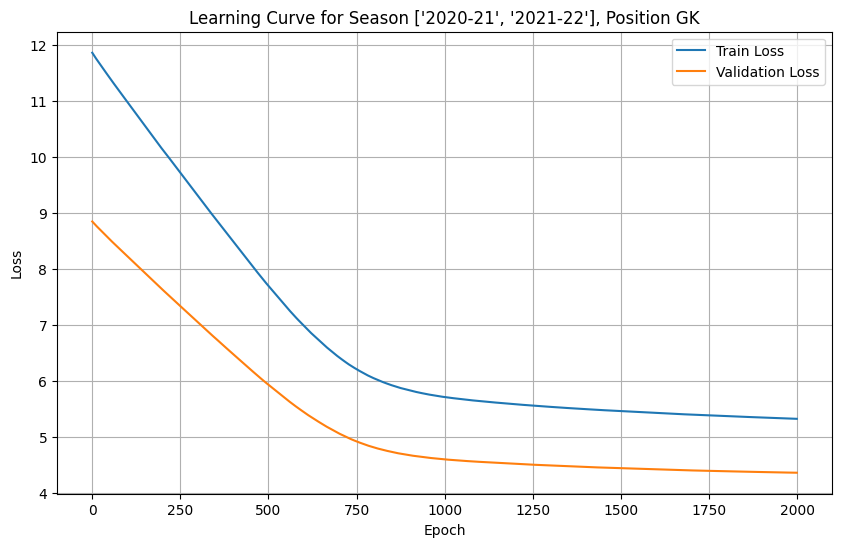

(CNNModel(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (conv2d): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
   (linear_relu_stack): Sequential(
     (0): Linear(in_features=145, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 {'test_mae': 1.6264150510648734})

In [5]:
SEED = 229

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'clean_data')

full_cnn_pipeline(DATA_DIR,
                season = ['2020-21', '2021-22'], 
                position = 'GK', 
                window_size=6,
                kernel_size=3,
                num_filters=6,
                num_dense=64,
                batch_size = 32,
                epochs = 2000,  
                drop_low_playtime = True,
                low_playtime_cutoff = 1e-6,
                num_features = NUM_FEATURES_DICT['GK']['large'],
                cat_features = STANDARD_CAT_FEATURES, 
                stratify_by = 'stdev', 
                conv_activation = 'relu',
                dense_activation = 'relu',
                optimizer='adam',
                learning_rate= 0.000001,  
                loss = 'mse',
                metrics = ['mae'],
                verbose = True,
                regularization = 0.01, 
                early_stopping = True, 
                tolerance = 1e-5, # only used if early stopping is turned on, threshold to define low val loss decrease
                patience = 20,   # num of iterations before early stopping bc of low val loss decrease
                plot = True, 
                draw_model = False,
                standardize= True,)

# GridSearch for Best Model

In [9]:
from final_project.cnn2d.experiment import gridsearch_cnn

gridsearch_cnn(experiment_name="cnn_2d_gk", verbose=False)

#PERFORMING VIA COMMAND LINE SCRIPT NOW FOR EFFICIENCY

===== Total Number of Iterations:  6


  0%|          | 0/6 [00:00<?, ?it/s]

===== Running Experiment for Parameters: =====
 {'seed': 400, 'position': 'GK', 'window_size': 6, 'num_dense': 64, 'tolerance': 0.0001, 'amt_num_features': 'large', 'stratify_by': 'stdev'}

seed 400
position GK
window_size 6
num_dense 64
tolerance 0.0001
amt_num_features large
stratify_by stdev
Running Iteration:  0
Epoch 1/750, Train Loss: 9.532903823956058, Val Loss: 6.050033757160968, Val MAE: 1.3708890676498413
Epoch 2/750, Train Loss: 7.091832490271435, Val Loss: 4.836160622149941, Val MAE: 1.268945336341858
Epoch 3/750, Train Loss: 5.895921195378297, Val Loss: 4.378261085077534, Val MAE: 1.2924792766571045
Epoch 4/750, Train Loss: 5.4557939927969406, Val Loss: 4.260883070047446, Val MAE: 1.320525050163269
Epoch 5/750, Train Loss: 5.312854018916592, Val Loss: 4.232095880583516, Val MAE: 1.3313206434249878
Epoch 6/750, Train Loss: 5.250508269590794, Val Loss: 4.219717365385979, Val MAE: 1.3156825304031372
Epoch 7/750, Train Loss: 5.216082090923874, Val Loss: 4.216196618845144, Val 

 17%|█▋        | 1/6 [00:11<00:55, 11.05s/it]

Epoch 63/750, Train Loss: 4.742922413017565, Val Loss: 4.183592261033734, Val MAE: 1.291318416595459
Epoch 64/750, Train Loss: 4.74161289836529, Val Loss: 4.1840561280569695, Val MAE: 1.2986146211624146
Early stopping
Test Loss (MSE): 6.219419002532959
Test Mean Absolute Error (MAE): 1.640297709928669
===== Running Experiment for Parameters: =====
 {'seed': 401, 'position': 'GK', 'window_size': 6, 'num_dense': 64, 'tolerance': 0.0001, 'amt_num_features': 'large', 'stratify_by': 'stdev'}

seed 401
position GK
window_size 6
num_dense 64
tolerance 0.0001
amt_num_features large
stratify_by stdev
Running Iteration:  1
Epoch 1/750, Train Loss: 8.670582514927254, Val Loss: 8.214560693073738, Val MAE: 1.5819294452667236
Epoch 2/750, Train Loss: 6.16797861845597, Val Loss: 6.363329891096707, Val MAE: 1.4279330968856812
Epoch 3/750, Train Loss: 5.14169823012737, Val Loss: 5.8034652135330225, Val MAE: 1.4937920570373535
Epoch 4/750, Train Loss: 4.8678507790062, Val Loss: 5.7038653698099315, Val M

 33%|███▎      | 2/6 [00:16<00:32,  8.04s/it]

Epoch 25/750, Train Loss: 4.495806095763023, Val Loss: 5.764225619671932, Val MAE: 1.6107170581817627
Epoch 26/750, Train Loss: 4.499744471555911, Val Loss: 5.762889217753806, Val MAE: 1.5904847383499146
Early stopping
Test Loss (MSE): 5.073462963104248
Test Mean Absolute Error (MAE): 1.552388937172422
===== Running Experiment for Parameters: =====
 {'seed': 402, 'position': 'GK', 'window_size': 6, 'num_dense': 64, 'tolerance': 0.0001, 'amt_num_features': 'large', 'stratify_by': 'stdev'}

seed 402
position GK
window_size 6
num_dense 64
tolerance 0.0001
amt_num_features large
stratify_by stdev
Running Iteration:  2
Epoch 1/750, Train Loss: 8.664784403094218, Val Loss: 8.777210263198432, Val MAE: 1.7322840690612793
Epoch 2/750, Train Loss: 5.941652948327461, Val Loss: 6.649761963166652, Val MAE: 1.576332688331604
Epoch 3/750, Train Loss: 5.000201251308262, Val Loss: 6.156170678035223, Val MAE: 1.6077051162719727
Epoch 4/750, Train Loss: 4.811476080128995, Val Loss: 6.030959824922288, Val

 50%|█████     | 3/6 [00:26<00:25,  8.54s/it]

Epoch 51/750, Train Loss: 4.380264687988623, Val Loss: 5.955125397435146, Val MAE: 1.6526963710784912
Early stopping
Test Loss (MSE): 5.00268030166626
Test Mean Absolute Error (MAE): 1.3848136586395545
===== Running Experiment for Parameters: =====
 {'seed': 403, 'position': 'GK', 'window_size': 6, 'num_dense': 64, 'tolerance': 0.0001, 'amt_num_features': 'large', 'stratify_by': 'stdev'}

seed 403
position GK
window_size 6
num_dense 64
tolerance 0.0001
amt_num_features large
stratify_by stdev
Running Iteration:  3
Epoch 1/750, Train Loss: 6.601691612618507, Val Loss: 10.852313934496747, Val MAE: 2.071204662322998
Epoch 2/750, Train Loss: 4.731387855000579, Val Loss: 8.153987675178342, Val MAE: 1.805308222770691
Epoch 3/750, Train Loss: 4.077954717454194, Val Loss: 7.4943951459434945, Val MAE: 1.8184692859649658
Epoch 4/750, Train Loss: 3.951732886319905, Val Loss: 7.280326487378376, Val MAE: 1.8496254682540894
Epoch 5/750, Train Loss: 3.902385708913638, Val Loss: 7.26536681555151, Val 

 67%|██████▋   | 4/6 [00:32<00:15,  7.51s/it]

Epoch 27/750, Train Loss: 3.6405523939628823, Val Loss: 7.33852248424437, Val MAE: 1.878535509109497
Early stopping
Test Loss (MSE): 6.357857704162598
Test Mean Absolute Error (MAE): 1.7097733468113552
===== Running Experiment for Parameters: =====
 {'seed': 404, 'position': 'GK', 'window_size': 6, 'num_dense': 64, 'tolerance': 0.0001, 'amt_num_features': 'large', 'stratify_by': 'stdev'}

seed 404
position GK
window_size 6
num_dense 64
tolerance 0.0001
amt_num_features large
stratify_by stdev
Running Iteration:  4
Epoch 1/750, Train Loss: 9.333599421708495, Val Loss: 7.265775648856556, Val MAE: 1.5713489055633545
Epoch 2/750, Train Loss: 6.486102101541591, Val Loss: 5.498603504811951, Val MAE: 1.4496772289276123
Epoch 3/750, Train Loss: 5.505146211537632, Val Loss: 5.136376850552612, Val MAE: 1.476633071899414
Epoch 4/750, Train Loss: 5.327093444485605, Val Loss: 5.088814339631206, Val MAE: 1.5011605024337769
Epoch 5/750, Train Loss: 5.291638423434243, Val Loss: 5.076962441580262, Val 

 83%|████████▎ | 5/6 [00:39<00:07,  7.65s/it]

Epoch 41/750, Train Loss: 4.980516727564239, Val Loss: 5.060458962078933, Val MAE: 1.499809741973877
Early stopping
Test Loss (MSE): 4.549375057220459
Test Mean Absolute Error (MAE): 1.283268077690903
===== Running Experiment for Parameters: =====
 {'seed': 405, 'position': 'GK', 'window_size': 6, 'num_dense': 64, 'tolerance': 0.0001, 'amt_num_features': 'large', 'stratify_by': 'stdev'}

seed 405
position GK
window_size 6
num_dense 64
tolerance 0.0001
amt_num_features large
stratify_by stdev
Running Iteration:  5
Epoch 1/750, Train Loss: 9.707776188767905, Val Loss: 7.389597045050727, Val MAE: 1.515391230583191
Epoch 2/750, Train Loss: 6.992338761326351, Val Loss: 5.795730248676593, Val MAE: 1.4100865125656128
Epoch 3/750, Train Loss: 5.559889472727132, Val Loss: 5.34479600909357, Val MAE: 1.4387606382369995
Epoch 4/750, Train Loss: 5.170362577058865, Val Loss: 5.309078242297463, Val MAE: 1.4730409383773804
Epoch 5/750, Train Loss: 5.073840613678665, Val Loss: 5.31552710033172, Val MAE

100%|██████████| 6/6 [00:52<00:00,  8.68s/it]

Epoch 75/750, Train Loss: 4.602231385056123, Val Loss: 5.174055634156826, Val MAE: 1.475074291229248
Early stopping
Test Loss (MSE): 5.178800582885742
Test Mean Absolute Error (MAE): 1.589289438086406
Logging experiment results to gridsearch\results\cnn_2d_gk_12-11.csv.



c:\Users\Dean\Code\csci-567\final_project\ml-premier-predictor\final_project\cnn2d\..\..\final_project\cnn2d\experiment.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, experiment_df], ignore_index=True)


## Investigate GridSearch Results

## Learning Curve, Filter Investigation

In [ ]:
def investigate_model(expt_name: str = 'gridsearch', 
                      drop_low_playtime: bool = True,
                      **kwargs):
    """
    Investigate the best model for the given experiment and drop status.

    Retrains the model on the same exact data split (to avoid data leakage), and
    generates learning curves.
    """
    season =  "['2020-21', '2021-22']"
    best_params = gridsearch_analysis(expt_name, 
                        season=season, 
                        eval_top=1,
                        drop_low_playtime=drop_low_playtime,
                        **kwargs)
    
    POSITIONS = ['GK', 'DEF', 'MID', 'FWD']
    best_models = {}
    for position in POSITIONS: 

        print(f"\n======= Retraining and Filter Analysis for {position} model: =======\n")
        # Clean up and consolidate parameters in the 'params' dictionary
        params = best_params.loc[position, :].to_dict()

        serialized_dataset = params.pop('dataset')
        dataset = pickle.loads(ast.literal_eval(serialized_dataset))

        # Retrieve individual datasets
        X_train = dataset['X_train']
        d_train = dataset['d_train']
        y_train = dataset['y_train']
        X_val = dataset['X_val']
        d_val = dataset['d_val']
        y_val = dataset['y_val']
        X_test = dataset['X_test']
        d_test = dataset['d_test']
        y_test = dataset['y_test']

        serialized_pipeline = params.pop('pipeline')
        pipeline = pickle.loads(ast.literal_eval(serialized_pipeline))

        params['season'] = ['2020-21', '2021-22']
        params['metrics'] = ['mae']
        params['num_features'] = NUM_FEATURES_DICT[params['position']][params.pop('amt_num_features')]
        params.pop('stratify_by')  #don't need this, we have the pickled split data 

        # Add the datasets to params
        params.update({
            'X_train': X_train,
            'd_train': d_train,
            'y_train': y_train,
            'X_val': X_val,
            'd_val': d_val,
            'y_val': y_val,
            'X_test': X_test,
            'd_test': d_test,
            'y_test': y_test,
            'plot': True,
        })

        # =========== Qualitative Analysis of Best & Worst Ex =============

        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")

        model, expt_res = build_train_cnn(**params)
        best_models[position] = model

        y_pred = model.predict([X_test, d_test])
        y_test_flattened = y_test.flatten()
        y_pred_flattened = y_pred.flatten()
        mse_per_example = np.square(y_test_flattened - y_pred_flattened)

        results_df = pd.DataFrame({'Actual Score': y_test_flattened, 'Predicted Score': y_pred_flattened, 'MSE': mse_per_example})
        results_df['d_test'] = d_test

        # Add X_test features to the DataFrame
        # unstandardize the features
        X_test_original = X_test.copy()

        # Calculate unstandardized pts
        numerical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num']
        X_test_reshaped = X_test_original.reshape(-1, X_test_original.shape[-1])
        X_test_unstandardized = numerical_transformer.inverse_transform(X_test_reshaped).astype(int)
        X_test_unstandardized = X_test_unstandardized.reshape(X_test_original.shape)
        X_test_unstandardized_2d = X_test_unstandardized.reshape(X_test_unstandardized.shape[0], -1)
        column_names = [f'pts_week{i}' for i in range(X_test_unstandardized_2d.shape[1])]
        unstandardized_df = pd.DataFrame(X_test_unstandardized_2d, columns=column_names)

        results_df = pd.concat([results_df, unstandardized_df], axis=1)

        results_df.sort_values(by='MSE', ascending=False, inplace=True)

        print(f"\nWorst two examples for {position}:\n")
        display(results_df.head(2))

        print(f"\nBest two examples for {position}:\n")
        display(results_df.tail(2))


        for layer in model.layers:
            if 'conv' not in layer.name:
                continue
            filters, biases = layer.get_weights()

        # retrieve filter weights from the second hidden layer
        filters, biases = model.layers[1].get_weights()

        # normalize filter values by z-score normalization
        mean_value, std_dev = filters.mean(), filters.std()
        normalized_filters = (filters - mean_value) / std_dev
        mean_filter = normalized_filters.mean(axis=-1)

        # set greyscale color map
        cmap = plt.cm.Greys_r
        cmap.set_bad('0.5')  # Set the color for NaN values (if any) to medium-grey

        # plot the normalized average filter with numeric values inside pixels
        fig, ax = plt.subplots()
        img = ax.imshow(mean_filter, cmap=cmap, vmin=-1, vmax=1)

        # add text annotations with normalized values inside each pixel
        for i, value in enumerate(mean_filter):
            value = value[0]
            # set text color based on brightness
            text_color = 'white' if value < 0 else 'black'
            ax.text(0, i, f"{value:.4f}", ha='center', va='center', fontsize=8, color=text_color)
        ax.set_title(f"Averaged 1D Convolution Filter (Normalized) — {position}")
        ax.axis('off')
        plt.show()

    return best_models


# V12 (overfits)

In [ ]:
#best_models = investigate_model('gridsearch_v12', drop_low_playtime=True, stratify_by='stdev')

## V11 (stratified by stdev score)

### Drop Model

In [ ]:
# model with drop benched players
#best_models = investigate_model('gridsearch_v11', drop_low_playtime=True, stratify_by='stdev')

### Easy Model (Full Data)

In [ ]:
# easier model
#best_models = investigate_model('gridsearch_v11', drop_low_playtime=False, stratify_by='stdev')

## Worse Stability with 'Skill' instead of 'stdev'? 
### Ans: No Significant Diff. -> Skill the better stratification for performance based on top 1 and top 5


In [ ]:
gridsearch_analysis('gridsearch_v11', drop_low_playtime=True, stratify_by='skill', eval_top=1)

In [ ]:
print(f"\n ========= Interesting Model (DROP BENCHWARMERS) ==========")
best_models = investigate_model('gridsearch_v11', drop_low_playtime=True, stratify_by='skill')

In [ ]:
#print(f"\n ========= Easier Model (FULL DATA) ==========")
#best_models = investigate_model('gridsearch_v11', drop_low_playtime=False, stratify_by='skill')

## Top 1 and Top 5 Performances

In [ ]:
gridsearch_analysis('gridsearch_v11', 
                    stratify_by='skill', 
                    eval_top=2, 
                    drop_low_playtime = True)

In [ ]:
def investigate_model_v0(expt_name: str = 'gridsearch', 
                      drop_low_playtime: bool = True,
                      **kwargs):
    """
    Investigate the best model for the given experiment and drop status.

    Retrains the model on the same exact data split (to avoid data leakage), and
    generates learning curves.
    """
    season =  "['2020-21', '2021-22']"
    best_params = gridsearch_analysis(expt_name, 
                        season=season, 
                        eval_top=1,
                        drop_low_playtime=drop_low_playtime,
                        **kwargs)
    
    POSITIONS = ['GK', 'DEF', 'MID', 'FWD']
    best_models = {}
    for position in POSITIONS: 

        print(f"\n======= Retraining and Filter Analysis for {position} model: =======\n")
        # Clean up and consolidate parameters in the 'params' dictionary
        params = best_params.loc[position, :].to_dict()

        serialized_dataset = params.pop('dataset')
        dataset = pickle.loads(ast.literal_eval(serialized_dataset))

        # Retrieve individual datasets
        X_train = dataset['X_train']
        d_train = dataset['d_train']
        y_train = dataset['y_train']
        X_val = dataset['X_val']
        d_val = dataset['d_val']
        y_val = dataset['y_val']
        X_test = dataset['X_test']
        d_test = dataset['d_test']
        y_test = dataset['y_test']

        serialized_pipeline = params.pop('pipeline')
        pipeline = pickle.loads(ast.literal_eval(serialized_pipeline))

        params['season'] = ['2020-21', '2021-22']
        params['metrics'] = ['mae']
        params['num_features'] = NUM_FEATURES_DICT[params['position']][params.pop('amt_num_features')]

        # Add the datasets to params
        params.update({
            'X_train': X_train,
            'd_train': d_train,
            'y_train': y_train,
            'X_val': X_val,
            'd_val': d_val,
            'y_val': y_val,
            'X_test': X_test,
            'd_test': d_test,
            'y_test': y_test,
            'plot': True,
        })

        # =========== Qualitative Analysis of Best & Worst Ex =============

        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")

        model, expt_res = build_train_cnn(**params)
        best_models[position] = model

        y_pred = model.predict([X_test, d_test])
        y_test_flattened = y_test.flatten()
        y_pred_flattened = y_pred.flatten()
        mse_per_example = np.square(y_test_flattened - y_pred_flattened)

        results_df = pd.DataFrame({'Actual Score': y_test_flattened, 'Predicted Score': y_pred_flattened, 'MSE': mse_per_example})
        results_df['d_test'] = d_test

        # Add X_test features to the DataFrame
        # unstandardize the features
        X_test_original = X_test.copy()

        # Calculate unstandardized pts
        numerical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num']
        X_test_reshaped = X_test_original.reshape(-1, X_test_original.shape[-1])
        X_test_unstandardized = numerical_transformer.inverse_transform(X_test_reshaped).astype(int)
        X_test_unstandardized = X_test_unstandardized.reshape(X_test_original.shape)
        X_test_unstandardized_2d = X_test_unstandardized.reshape(X_test_unstandardized.shape[0], -1)
        column_names = [f'pts_week{i}' for i in range(X_test_unstandardized.shape[1])]
        unstandardized_df = pd.DataFrame(X_test_unstandardized_2d, columns=column_names)

        results_df = pd.concat([results_df, unstandardized_df], axis=1)

        results_df.sort_values(by='MSE', ascending=False, inplace=True)

        print(f"\nWorst two examples for {position}:\n")
        display(results_df.head(2))

        print(f"\nBest two examples for {position}:\n")
        display(results_df.tail(2))


        for layer in model.layers:
            if 'conv' not in layer.name:
                continue
            filters, biases = layer.get_weights()

        # retrieve filter weights from the second hidden layer
        filters, biases = model.layers[1].get_weights()

        # normalize filter values by z-score normalization
        mean_value, std_dev = filters.mean(), filters.std()
        normalized_filters = (filters - mean_value) / std_dev
        mean_filter = normalized_filters.mean(axis=-1)

        # set greyscale color map
        cmap = plt.cm.Greys_r
        cmap.set_bad('0.5')  # Set the color for NaN values (if any) to medium-grey

        # plot the normalized average filter with numeric values inside pixels
        fig, ax = plt.subplots()
        img = ax.imshow(mean_filter, cmap=cmap, vmin=-1, vmax=1)

        # add text annotations with normalized values inside each pixel
        for i, value in enumerate(mean_filter):
            value = value[0]
            # set text color based on brightness
            text_color = 'white' if value < 0 else 'black'
            ax.text(0, i, f"{value:.4f}", ha='center', va='center', fontsize=8, color=text_color)
        ax.set_title("Averaged 1D Convolution Filter (Normalized)")
        ax.axis('off')
        plt.show()

    return best_models

## V10

In [ ]:
# easier model
#best_models = investigate_model_v0('gridsearch_v10', drop_low_playtime=False)

## DROP model

In [ ]:
# model with drop benched players
#best_models = investigate_model_v0('gridsearch_v10', drop_low_playtime=True)

## V9

In [ ]:
#best_models = investigate_model_v0('gridsearch_v9', drop_low_playtime=True)

## V8

In [ ]:
# with player dropping
"""
best_params = gridsearch_analysis('gridsearch_v8', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = True)
"""

In [ ]:
# with player dropping
"""
best_hyperparams = gridsearch_analysis('gridsearch_v8', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = False)
"""

## V7


In [ ]:
# with player dropping
"""
gridsearch_analysis('gridsearch_v7', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = True)
"""

In [ ]:
# without player dropping
"""
gridsearch_analysis('gridsearch_v7', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = False)
"""

## V6  With Player Dropping

In [ ]:
"""
gridsearch_analysis('gridsearch_v6', 
                    season="['2020-21', '2021-22']", 
                    eval_top=5,
                    drop_low_playtime = True)
"""

## V6 Best Models Without Player Dropping

In [ ]:
"""gridsearch_analysis('gridsearch_v6', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    num_dense=64,
                    num_filters=64,
                    amt_num_features = 'ptsonly',
                    drop_low_playtime = True)"""

## Other Models

In [ ]:
"""gridsearch_analysis('_gridsearch_v4', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1)"""

In [ ]:
"""gridsearch_analysis('gridsearch_v4_singleyear_drop', 
                    season='2020-21',
                    eval_top=1)"""

In [ ]:
"""gridsearch_analysis('gridsearch_v4_singleyear_drop', 
                    season='2021-22',
                    eval_top=1)"""

In [ ]:
"""gridsearch_analysis('gridsearch_v5', eval_top=3)"""

In [ ]:
"""best_hyperparams = gridsearch_analysis('gridsearch_v4_optimal_drop', 
                    eval_top=1)"""